In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

import random
import math
import networkx as nx

import boto3
from PIL import Image

import requests
import json

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)

In [2]:
# # Visualize the images and their annotations
# image_identifiers = list(image_paths.keys())
# random.shuffle(image_identifiers) 
# for image_id in image_identifiers:
#     image_path = image_paths[image_id]
#     image = plt.imread(image_path)
#     bbox = image_bboxes[image_id]
#     parts = image_parts[image_id]
#     class_label = image_class_labels[image_id]
#     class_name = class_names[class_label]
      
#     # Render the image
#     plt.close(1)
#     fig = plt.figure(1, figsize=(16, 12))
#     plt.imshow(image)
#     plt.title("Image ID: %s \n Class Label: %s  [ID: %s]" % (image_id, class_name, class_label))
      
#     # Render the bounding box annotations
#     bbox_x, bbox_y, bbox_width, bbox_height = bbox
#     currentAxis = plt.gca()
#     currentAxis.add_patch(plt.Rectangle((bbox_x , bbox_y), bbox_width, bbox_height, facecolor="green", alpha=0.3))
      
#     # Render the part annotations
#     if has_networkx:
#     # Use networkx spring layout
        
#         G = nx.Graph()
#         part_data = []
#         initial_positions = {}
#         for part_id, part in enumerate(parts):
#             x, y, v = part
#             if v:
#                 part_str = 'part_%d' % (part_id,)
#                 label_str = 'label_%d' % (part_id,)
            
#                 G.add_node(part_str)
#                 G.add_node(label_str)
#                 G.add_edge(part_str, label_str)
            
#                 part_data.append(part_str)
            
#                 initial_positions[part_str] = (x, y)
#                 initial_positions[label_str] = (x, y)
            
#             positions = nx.spring_layout(G, dim=2, k=20.0, pos=initial_positions, fixed=part_data)
        
#             for part_id, part in enumerate(parts):
#                 x, y, v = part
#                 if v:
#                     plt.plot(x, y, 'o')
            
#                     label_str = 'label_%d' % (part_id,)
#                     label_position = positions[label_str]
#                     label_xy = (label_position[0] * bbox_width + bbox_x, label_position[1] * bbox_height + bbox_y)
#                     plt.annotate(
#                       part_names[part_id], 
#                       xy=(x, y),
#                       xycoords='data', 
#                       xytext= label_xy, 
#                       textcoords='data',
#                       ha='right', 
#                       va='bottom',
#                       bbox=dict(boxstyle= 'round,pad=0.5', 
#                             fc='yellow', 
#                             alpha=0.5),
#                       arrowprops=dict(arrowstyle='->', 
#                               connectionstyle='arc3,rad=0')
#                     )
    
#                 else:
#                     # just a basic label annotation for the part locations
#                     offset = (2 * math.pi) / len(parts)
#                     for part_id, part in enumerate(parts):
#                         x, y, v = part
#                         if v: 
#                             # try to offset the part labels so that they don't overlap too badly
#                             dist = random.randint(35, 65)
#                             offset_x = dist * math.cos(offset * part_id)
#                             offset_y = dist * math.sin(offset * part_id)
          
#                             plt.plot(x, y, 'o')
#                             plt.annotate(
#                               part_names[part_id], 
#                               xy=(x, y), 
#                               xytext=(offset_x, offset_y), 
#                               textcoords='offset points', 
#                               ha='right', 
#                               va='bottom',
#                               bbox=dict(boxstyle= 'round,pad=0.5', 
#                                 fc='yellow', 
#                                 alpha=0.5),
#                               arrowprops=dict(arrowstyle='->', 
#                                   connectionstyle='arc3,rad=0')
#                             )
  
#     plt.show(block=False)

In [3]:
# def rename_multiple_files(path,obj):

#     i=0

#     for filename in os.listdir(path):
#         try:
#             f,extension = os.path.splitext(path+filename)
#             src=path+'/'+filename
#             dst=path+'/'+obj+str(i)+extension
#             os.rename(src,dst)
#             i+=1
#             print('Rename successful.')
#         except:
#             i+=1

# path='training_set'
# obj=f"{src_path.split('.')[1]}"
# rename_multiple_files(path,obj)

In [4]:
# keras and tensorflow downloads
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D # CNN
from tensorflow.keras.callbacks import TensorBoard # graphical visual of loss and accuracy over the epochs of train and test set

import pickle # save images
import time # get time stamp of models trained

## Import text files (image names, labels)

In [2]:
import matplotlib.image as mpimg # show images
from io import BytesIO # reading bytes

#### Create dataframe with images.txt

_Contains name of images and file path_  
- Split into file path, image name, and folder number

In [3]:
bucket = 'cwbirdsimages'
img_dir = 'images'

In [4]:
s3 = boto3.client('s3')
img_txt = s3.get_object(Bucket=bucket, Key='images.txt')

img_names = BytesIO(img_txt['Body'].read())

In [5]:
img_data = pd.read_csv(img_names, header=None, low_memory=False, na_values='n/a')

In [6]:
img_data['file_path'] = img_data[0].apply(lambda x: x.split()[1])
img_data['img_name'] = img_data[0].apply(lambda x: x.split()[0])

img_data['class_id'] = img_data['file_path'].apply(lambda x: x.split('/')[0])

In [7]:
img_data.drop(0, axis=1, inplace=True)

In [8]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48562 entries, 0 to 48561
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  48562 non-null  object
 1   img_name   48562 non-null  object
 2   class_id   48562 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [9]:
img_data['class_id'] = img_data['class_id'].apply(lambda x: int(x))

#### Create dataframe of image_class_labels.txt

_Contains name of image file and corresponding folder number_  
- Split into image name, and folder number

In [10]:
s3 = boto3.client('s3')
img_class = s3.get_object(Bucket=bucket, Key='image_class_labels.txt')

img_class_labels = BytesIO(img_class['Body'].read())

In [11]:
labels_df = pd.read_csv(img_class_labels, header=None, low_memory=False, na_values='n/a')

In [12]:
labels_df

,0
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829 817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b 860
2,00019306-9d83-4334-b255-a447742edce3 900
3,0001afd4-99a1-4a67-b940-d419413e23b3 645
4,000332b8-997c-4540-9647-2f0a8495aecf 929
...,...
48557,fff86e8b-795f-400a-91e8-565bbb8c453a 891
48558,fff926d7-ccad-4788-839e-97af2dd99372 660
48559,fffa33ef-a765-408d-8d66-6efc7f504c71 492
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce 372


In [13]:
labels_df['img_name'] = labels_df[0].apply(lambda x: x.split()[0])
labels_df['class_id'] = labels_df[0].apply(lambda x: x.split()[1])

In [14]:
labels_df.drop(0, axis=1, inplace=True)

In [15]:
labels_df

,img_name,class_id
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,860
2,00019306-9d83-4334-b255-a447742edce3,900
3,0001afd4-99a1-4a67-b940-d419413e23b3,645
4,000332b8-997c-4540-9647-2f0a8495aecf,929
...,...,...
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,891
48558,fff926d7-ccad-4788-839e-97af2dd99372,660
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,492
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,372


#### Create dataframe with hierarchy.txt

_Contains folder number and class number_  
- Split into folder number and class number

In [16]:
s3 = boto3.client('s3')
hierarchy_txt = s3.get_object(Bucket=bucket, Key='hierarchy.txt')

hierarchy = BytesIO(hierarchy_txt['Body'].read())

In [17]:
hier_df = pd.read_csv(hierarchy, header=None, low_memory=False, na_values='n/a')

In [18]:
hier_df.head()

,0
0,1 0
1,2 0
2,3 0
3,4 0
4,5 0


In [19]:
hier_df['folder_num'] = hier_df[0].apply(lambda x: x.split()[0])
hier_df['class_id'] = hier_df[0].apply(lambda x: x.split()[1])

In [20]:
hier_df.drop(0, axis=1, inplace=True)

In [21]:
hier_df

,folder_num,class_id
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
1005,1006,591
1006,1007,259
1007,1008,704
1008,1009,691


#### Create dataframe with classes.txt

_Contains class number and class labels_  
- Split into class number and class labels_

In [22]:
s3 = boto3.client('s3')
classes_txt = s3.get_object(Bucket=bucket, Key='classes.txt')

classes = BytesIO(classes_txt['Body'].read())

In [23]:
classes_df = pd.read_csv(classes, sep='\t', header=None, low_memory=False, na_values='n/a')

In [24]:
classes_df.head()

,0
0,0 Birds
1,"1 Ducks, Geese, and Swans"
2,"2 Grouse, Quail, and Allies"
3,3 Loons
4,4 Grebes


In [25]:
classes_df['class_id'] = classes_df[0].apply(lambda x: x.split(' ', 1)[0])
classes_df['txt_labels'] = classes_df[0].apply(lambda x: x.split(' ', 1)[1])

In [26]:
classes_df.drop(0, axis=1, inplace=True)

In [27]:
classes_df['class_id'] = classes_df['class_id'].apply(lambda x: int(x))

## Merge all dataframes

The folder numbers corresponds to the class ids
merge the **img_data** dataframe (containing file path, image name, and class id) and the **classes_df** dataframe (class id and txt_labels)

In [74]:
master_df = img_data.merge(classes_df, on='class_id')

In [76]:
master_df[master_df['class_id'] == 295]

,file_path,img_name,class_id,txt_labels
24186,0295/01f53d6bf5e449438d2bb79e0854bca4.jpg,01f53d6b-f5e4-4943-8d2b-b79e0854bca4,295,Common Eider (Adult male)
24187,0295/074a068d75404dfc9e37bffc8b37265e.jpg,074a068d-7540-4dfc-9e37-bffc8b37265e,295,Common Eider (Adult male)
24188,0295/0daddfcbc9a54170ac06402bffeff37c.jpg,0daddfcb-c9a5-4170-ac06-402bffeff37c,295,Common Eider (Adult male)
24189,0295/19371d9dd2874202b9c7948a5543ed2e.jpg,19371d9d-d287-4202-b9c7-948a5543ed2e,295,Common Eider (Adult male)
24190,0295/1fddd7c3b1b242eba5c020aaad4fb429.jpg,1fddd7c3-b1b2-42eb-a5c0-20aaad4fb429,295,Common Eider (Adult male)
24191,0295/223664da3e4d4d459a5a776ffd8a61ed.jpg,223664da-3e4d-4d45-9a5a-776ffd8a61ed,295,Common Eider (Adult male)
24192,0295/2b03c8b195ad4f73a1e622d3f56b6095.jpg,2b03c8b1-95ad-4f73-a1e6-22d3f56b6095,295,Common Eider (Adult male)
24193,0295/2f2b0586362346fd9b6d512e12144b85.jpg,2f2b0586-3623-46fd-9b6d-512e12144b85,295,Common Eider (Adult male)
24194,0295/45ccebf72c4645af8376c7fd1e0c7d45.jpg,45ccebf7-2c46-45af-8376-c7fd1e0c7d45,295,Common Eider (Adult male)
24195,0295/47a49d00958f4db18cca675579d11a05.jpg,47a49d00-958f-4db1-8cca-675579d11a05,295,Common Eider (Adult male)


In [30]:
master_df.shape

(48562, 4)

In [31]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48562 entries, 0 to 48561
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   48562 non-null  object
 1   img_name    48562 non-null  object
 2   class_id    48562 non-null  int64 
 3   txt_labels  48562 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


## Import images

In [77]:
please_work = []

for path in master_df['file_path'][24000:24200:5]:
    s3 = boto3.client('s3')
    try:
        obj_testing = s3.get_object(Bucket=bucket, Key=f'{img_dir}/{path}')
        got_image = BytesIO(obj_testing['Body'].read())
        test_57 = Image.open(got_image)
        img_array = np.array(test.resize((200,200)))
        please_work.append(img_array)
    except:
        continue

In [78]:
please_work

[array([[[ 89,  96,  95],
         [ 95,  99, 100],
         [ 97,  98, 101],
         ...,
         [ 76,  90,  88],
         [ 79,  91,  90],
         [ 88,  96,  97]],
 
        [[121, 133, 130],
         [ 98, 107, 107],
         [ 87,  92,  96],
         ...,
         [ 93, 105, 103],
         [ 93, 105, 104],
         [ 80,  90,  91]],
 
        [[134, 132, 134],
         [105, 109, 111],
         [ 90, 101, 102],
         ...,
         [108, 118, 114],
         [ 94, 104, 102],
         [ 90, 100, 100]],
 
        ...,
 
        [[ 82,  87,  94],
         [ 81,  88,  92],
         [ 85,  90,  94],
         ...,
         [205, 205, 199],
         [187, 188, 184],
         [164, 168, 166]],
 
        [[186, 188, 184],
         [193, 195, 191],
         [192, 193, 189],
         ...,
         [175, 173, 171],
         [169, 167, 164],
         [170, 171, 171]],
 
        [[190, 192, 185],
         [200, 202, 196],
         [203, 204, 200],
         ...,
         [212, 208, 207],
  

In [32]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=f'{img_dir}/0295/01f53d6bf5e449438d2bb79e0854bca4.jpg')

In [33]:
test_img = BytesIO(obj['Body'].read())
# im = mpimg.imread(data, 'jpg')

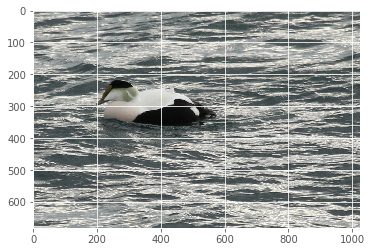

In [66]:
test = Image.open(test_img)
plt.imshow(test)

In [51]:
img_array = np.array(test.resize((200,200)))

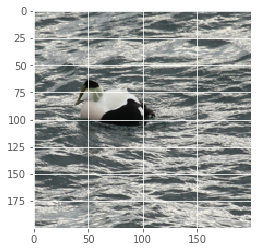

In [52]:
plt.imshow(img_array)

In [ ]:
from PIL import Image

def resize_multiple_images(src_folder, dst_path):
    # src_folder is the location where images are saved
    for dirpath, dirnames, filenames in os.walk(src_folder):
        for filename in os.listdir(dirpath):
            try:
                img=Image.open(filename+'.jpg')
                new_img = img.resize((64,64))
                if not os.path.exists(dst_path):
                    os.makedirs(dst_path)
                new_img.save(dst_path+'/'+filename)
                print('Resized and saved {}.'.format(filename))
            except:
                continue

# src_folder = 'images'
# dst_path = 'resized_images'
# resize_multiple_images(src_folder, dst_path)

In [ ]:
from PIL import Image
import os
import numpy as np
import re

def get_data(path):
    all_images_as_array=[]
    label=[]
    for filename in os.listdir(path):
        try:
            if re.match(r'Black_footed_Albatross',filename):
                label.append(1)
            else:
                label.append(0)
            img=Image.open(path + '/'+ filename)
            np_array = np.asarray(img)
            l,b,c = np_array.shape
            np_array = np_array.reshape(l*b*c,)
            all_images_as_array.append(np_array)
        except:
            continue

    return np.array(all_images_as_array), np.array(label)

# path_to_train_set = 'train_set/'
# path_to_test_set = 'test_set/'
# X_train,y_train = get_data(path_to_train_set)
# X_test, y_test = get_data(path_to_test_set)

# print('X_train set : ',X_train)
# print('y_train set : ',y_train)
# print('X_test set : ',X_test)
# print('y_test set : ',y_test)

In [ ]:
# def load_bounding_box_annotations(dataset_path=''):
#     bboxes = {}
#     with open(os.path.join(dataset_path, 'bounding_boxes.txt')) as f:
#         for line in f:
#             pieces = line.strip().split()
#             image_id = pieces[0]
#             bbox = map(int, pieces[1:])
#             bboxes[image_id] = bbox
#     return bboxes

# def load_part_annotations(dataset_path=''):
#     parts = {}
#     with open(os.path.join(dataset_path, 'parts/part_locs.txt')) as f:
#         for line in f:
#             pieces = line.strip().split()
#             image_id = pieces[0]
#             parts.setdefault(image_id, [0] * 11)
#             part_id = int(pieces[1])
#             parts[image_id][part_id] = [int(x) for x in pieces[2:]]
#     return parts  
  
# def load_part_names(dataset_path=''):
#     names = {}
#     with open(os.path.join(dataset_path, 'parts/parts.txt')) as f:
#         for line in f:
#             pieces = line.strip().split()
#             part_id = int(pieces[0])
#             names[part_id] = ' '.join(pieces[1:])
#     return names  

In [ ]:
def load_class_names(dataset_path=''):
    names = {}
    with open(os.path.join(dataset_path, 'classes.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            class_id = pieces[0]
            names[class_id] = ' '.join(pieces[1:])
    return names

In [ ]:
def load_image_labels(dataset_path=''):
    labels = {}
    with open(os.path.join(dataset_path, 'image_class_labels.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            image_id = pieces[0]
            class_id = pieces[1]
            labels[image_id] = class_id
    return labels

In [ ]:
        
def load_image_paths(dataset_path='', path_prefix=''):
    paths = {}
    with open(os.path.join(dataset_path, 'images.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            image_id = pieces[0]
            path = os.path.join(path_prefix, pieces[1])
            paths[image_id] = path
    return paths

In [ ]:
def load_image_sizes(dataset_path=''):
    sizes = {}
    with open(os.path.join(dataset_path, 'sizes.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            image_id = pieces[0]
            width, height = map(int, pieces[1:])
            sizes[image_id] = [width, height]
    return sizes

In [ ]:
def load_hierarchy(dataset_path=''):
    parents = {}
    with open(os.path.join(dataset_path, 'hierarchy.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            child_id, parent_id = pieces
            parents[child_id] = parent_id
    return parents

In [ ]:
def load_train_test_split(dataset_path=''):
    train_images = []
    test_images = []
    with open(os.path.join(dataset_path, 'train_test_split.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            image_id = pieces[0]
            is_train = int(pieces[1])
            if is_train:
                train_images.append(image_id)
            else:
                test_images.append(image_id)
    return train_images, test_images

In [ ]:
# def load_photographers(dataset_path=''):
#     photographers = {}
#     with open(os.path.join(dataset_path, 'photographers.txt')) as f:
#         for line in f:
#             pieces = line.strip().split()
#             image_id = pieces[0]
#             photographers[image_id] = ' '.join(pieces[1:])
#     return photographers

In [ ]:
dataset_path = 'nabirds/'
image_path  = 'nabirds/images'

In [ ]:
image_paths = load_image_paths(dataset_path, path_prefix=image_path)
image_sizes = load_image_sizes(dataset_path)
# image_bboxes = load_bounding_box_annotations(dataset_path)
# image_parts = load_part_annotations(dataset_path)
image_class_labels = load_image_labels(dataset_path)

In [ ]:
class_names = load_class_names(dataset_path)
class_hierarchy = load_hierarchy(dataset_path)

# Load in the part data
# part_names = load_part_names(dataset_path)
# part_ids = part_names.keys()
# part_ids = sorted(part_ids)

# Load in the photographers
# photographers = load_photographers(dataset_path)

# Load in the train / test split
train_images, test_images = load_train_test_split(dataset_path)

In [ ]:
# image_paths['0090914b-db16-4b8f-9f95-045d8a90d09d']

birds_filenames = [x for x in image_paths.values()]

print(birds_filenames[0])
print(len(birds_filenames))

image = Image.open(birds_filenames[3000])
print(np.array(image).shape)

fig, axes = plt.subplots(1, 4, figsize=(20,10))

axes[0].imshow(image)
axes[0].set_title('original')
for ax, channel, name in zip(axes[1:], image.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap='gray')
    ax.set_title(name)